# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

Using TensorFlow backend.


## Options

In [2]:
with open(dirLoc + 'features.pkl', 'rb') as fin:
    classTrainFeatures = pickle.load(fin)

In [3]:
nSplits = 10
patience = 50
maxEpochs = 200

ensembleSize = 10
ensembleMode = 'loss'

compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':'modelSwish', 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs, 'mode':'classifier'}

plot_while_training = True
custom_objects = {'swish': swish}

print ("\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures])

# expected signal and background numbers
s_exp = 691.988607714
b_exp = 410999.847322
print ('_S%.2e'%s_exp).replace('.', 'd').replace('+','p').replace('-','m')
print ('_B%.2e'%b_exp).replace('.', 'd').replace('+','p').replace('-','m')

custom_objects.update(get_losses_dict([0.001, 0.1, 0.3, 0.5], s_exp, b_exp))

def plotLoss(history):
    val_loss = history['val_loss']
    plt.plot(history['val_train_loss'],label='train')
    plt.plot(val_loss,label='test')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    if max(val_loss) > 20*min(val_loss) and min(val_loss)>0:
        plt.yscale('log')
    plt.legend(loc='best')
#    plt.savefig(os.path.join(self.output,'lossEvolution.pdf'))
#    plt.clf()
    plt.show()
    

('\nTraining on', 31, 'features:', ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py'])
_S6d92ep02
_B4d11ep05


## Import data

In [4]:
with open(dirLoc + 'inputPipe.pkl', 'rb') as fin:
    inputPipe = pickle.load(fin)

In [5]:
TargetModReader = get_BatchYielderTargetMod(RotationReflectionBatch)

trainData = RotationReflectionBatch(
    classTrainFeatures, h5py.File(dirLoc + 'train.hdf5', "r"),
    inputPipe=inputPipe, augRotMult=16
)
trainDataTargetMod = TargetModReader(
    classTrainFeatures, h5py.File(dirLoc + 'train.hdf5', "r"),
    inputPipe=inputPipe, augRotMult=16
)

nSplits = trainData.nFolds

## Determine LR

2 classes found, running in binary mode


______________________________________
Training finished
Cross-validation took 23.815s 


/nfs/dust/cms/user/tholenhe/installs/anaconda2/envs/hepML3/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


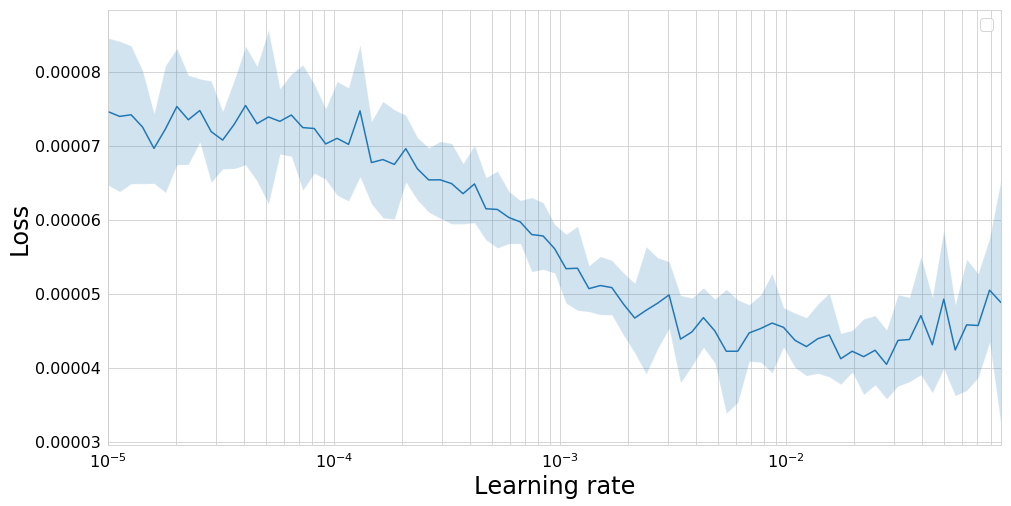

______________________________________



In [6]:
lrFinder = batchLRFind(trainData, getModel, modelParams, trainParams,
                       lrBounds=[1e-5,1e-1], trainOnWeights=True, verbose=0)

## Train classifier

In [6]:
newModelArgs = modelParams.copy()
#loss = custom_objects['asimovSignificanceLossInvert_Sys0p1_S6d92ep02_B4d11ep05']
loss = custom_objects['significanceLoss2Invert_S6d92ep02_B4d11ep05']
newModelArgs['compileArgs']['lr'] = 2e-4
newModelArgs['compileArgs']['loss'] = loss
trainParams['batch_size'] = 8192

#new_model = getModel(**newModelArgs)
#new_model.set_weights(model.get_weights())
#model = new_model

Using cosine annealing
Training using weights
Running fold 1 / 10
.2 classes found, running in binary mode


1 New best found: 2.28567560751e-07
.
2 New best found: 2.25860796135e-07
.
3 New best found: 2.23903688393e-07
.
4 New best found: 2.2154262696e-07
.
5 New best found: 2.17336736181e-07
.
6 New best found: 2.15335291902e-07
.
7 New best found: 2.14199998828e-07
.
8 New best found: 2.11376508426e-07
.
9 New best found: 2.08001153695e-07
.
10 New best found: 2.047431227e-07
.
11 New best found: 2.02668184783e-07
.
12 New best found: 2.00857379899e-07
.
13 New best found: 1.99899566512e-07
.
14 New best found: 1.99897090264e-07
.
15 New best found: 1.99538586162e-07
.
16 New best found: 1.97578097542e-07
.
17 New best found: 1.95169576831e-07
.
18 New best found: 1.93009300689e-07
.
19 New best found: 1.90552125933e-07
.
20 New best found: 1.8877729893e-07
.
21 New best found: 1.87209109136e-07
.
22 New best found: 1.8595124852e-07
.
23 New best found: 1.8486519347e-07
.
24 New be

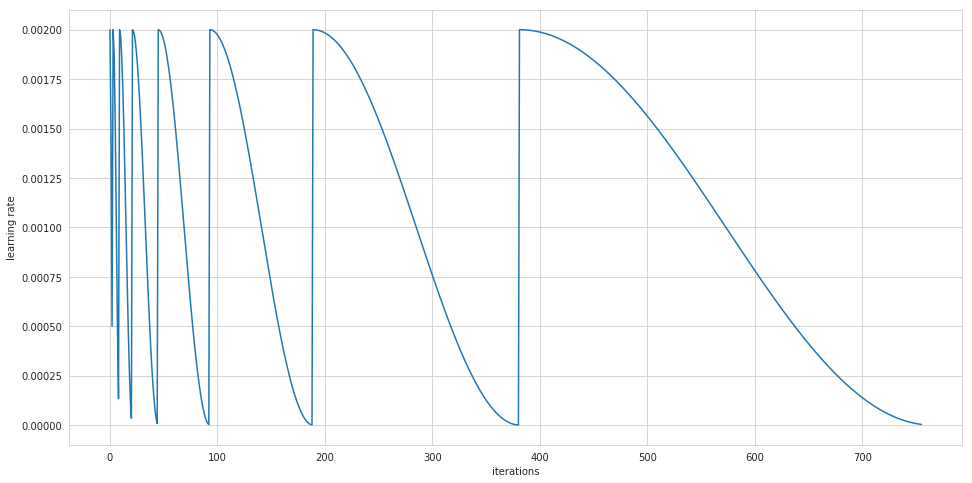

Fold took 469.671s

Running fold 2 / 10
.
1 New best found: 3.17355597682e-07
.
2 New best found: 3.00182051562e-07
.
3 New best found: 2.86854968596e-07
.
4 New best found: 2.69943589837e-07
.
5 New best found: 2.53432925822e-07
.
6 New best found: 2.44931700786e-07
.
7 New best found: 2.41950431811e-07
.
8 New best found: 2.33849904694e-07
.
9 New best found: 2.2393712019e-07
.
10 New best found: 2.15992528238e-07
.
11 New best found: 2.11967411138e-07
.
12 New best found: 2.08775772904e-07
.
13 New best found: 2.07619359883e-07
.
14 New best found: 2.06030509437e-07
..
16 New best found: 2.03229626637e-07
.
17 New best found: 1.99115849241e-07
.
18 New best found: 1.96135327118e-07
.
19 New best found: 1.92978599331e-07
.
20 New best found: 1.90711768411e-07
.
21 New best found: 1.8847989855e-07
.
22 New best found: 1.86973452515e-07
.
23 New best found: 1.85316886595e-07
.
24 New best found: 1.84456655427e-07
.
25 New best found: 1.83558179408e-07
.
26 New best found: 1.83220109368

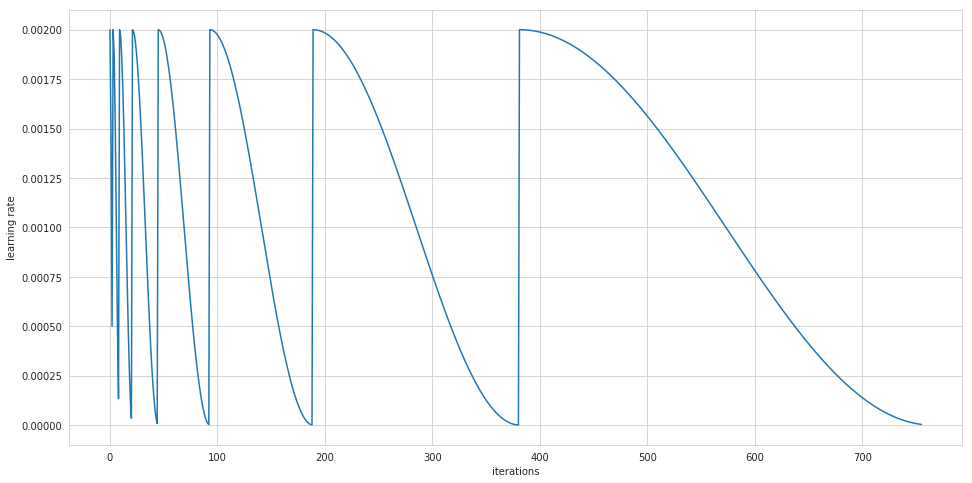

Fold took 607.192s

Running fold 3 / 10
.
1 New best found: 2.36220979436e-07
.
2 New best found: 2.31430331776e-07
.
3 New best found: 2.28522283673e-07
.
4 New best found: 2.24189019221e-07
.
5 New best found: 2.18240324829e-07
.
6 New best found: 2.15451441131e-07
.
7 New best found: 2.15013233433e-07
.
8 New best found: 2.10672225146e-07
.
9 New best found: 2.05744778167e-07
.
10 New best found: 2.02069320684e-07
.
11 New best found: 1.99150475907e-07
.
12 New best found: 1.96935001528e-07
.
13 New best found: 1.96200121454e-07
.
14 New best found: 1.9544334457e-07
.
15 New best found: 1.95431765872e-07
.
16 New best found: 1.93430225691e-07
.
17 New best found: 1.90264897982e-07
.
18 New best found: 1.87312796227e-07
.
19 New best found: 1.85097158772e-07
.
20 New best found: 1.83153116212e-07
.
21 New best found: 1.81643954334e-07
.
22 New best found: 1.79918744936e-07
.
23 New best found: 1.79081050967e-07
.
24 New best found: 1.77892547155e-07
.
25 New best found: 1.77368048129

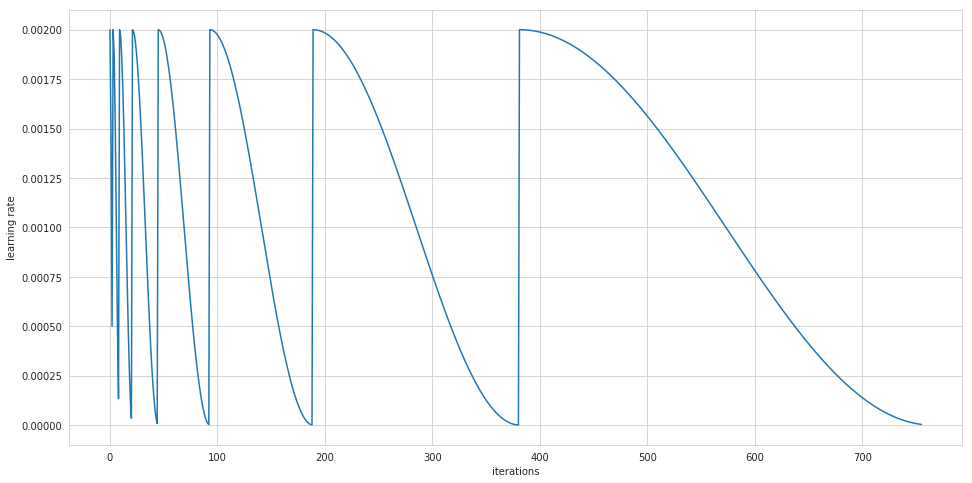

Fold took 601.048s

Running fold 4 / 10
.
1 New best found: 4.32693102562e-07
.
2 New best found: 4.01763451555e-07
.
3 New best found: 3.79342723704e-07
.
4 New best found: 3.44325325159e-07
.
5 New best found: 3.07842320103e-07
.
6 New best found: 2.8723659741e-07
.
7 New best found: 2.83494682685e-07
.
8 New best found: 2.58379791944e-07
.
9 New best found: 2.33044190782e-07
.
10 New best found: 2.17783727464e-07
.
11 New best found: 2.08285747647e-07
.
12 New best found: 2.03428641976e-07
.
13 New best found: 2.01070851733e-07
.
14 New best found: 2.00098000425e-07
.
15 New best found: 1.99784428958e-07
.
16 New best found: 1.95541942617e-07
.
17 New best found: 1.90747246779e-07
.
18 New best found: 1.87238057003e-07
.
19 New best found: 1.8429083774e-07
.
20 New best found: 1.81580649235e-07
.
21 New best found: 1.79727458988e-07
.
22 New best found: 1.77831086808e-07
.
23 New best found: 1.76386740907e-07
.
24 New best found: 1.75826652116e-07
.
25 New best found: 1.74800869831e

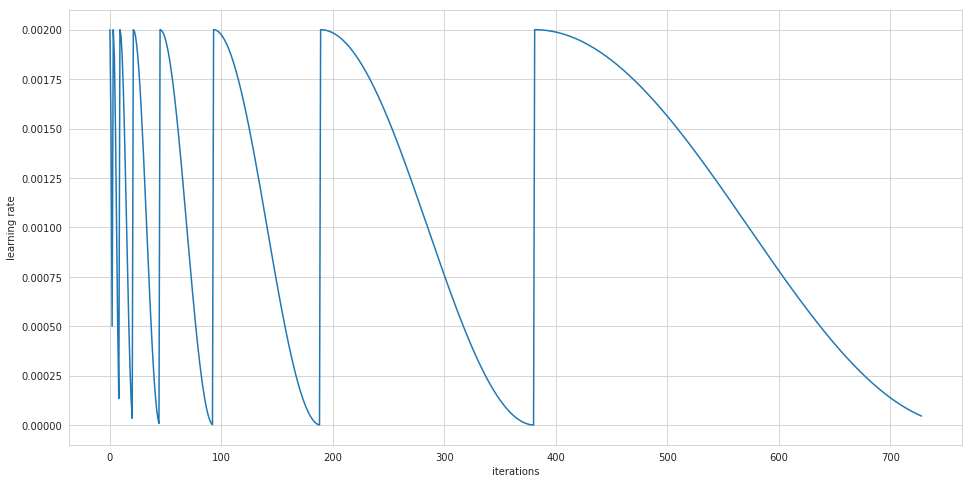

Fold took 582.475s

Running fold 5 / 10
.
1 New best found: 3.14852574525e-07
.
2 New best found: 2.98936486365e-07
.
3 New best found: 2.88836749246e-07
.
4 New best found: 2.75554910172e-07
.
5 New best found: 2.60689360539e-07
.
6 New best found: 2.50842207652e-07
.
7 New best found: 2.49211112327e-07
.
8 New best found: 2.39497274538e-07
.
9 New best found: 2.28467829004e-07
.
10 New best found: 2.206935505e-07
.
11 New best found: 2.14641014429e-07
.
12 New best found: 2.10695265707e-07
.
13 New best found: 2.0892046789e-07
.
14 New best found: 2.08416162604e-07
.
15 New best found: 2.08084320593e-07
.
16 New best found: 2.04537763545e-07
.
17 New best found: 2.00003926932e-07
.
18 New best found: 1.95473751728e-07
.
19 New best found: 1.92109374859e-07
.
20 New best found: 1.89248510378e-07
.
21 New best found: 1.87034190412e-07
.
22 New best found: 1.85082207759e-07
.
23 New best found: 1.83747903156e-07
.
24 New best found: 1.82542525101e-07
.
25 New best found: 1.82124789319e-

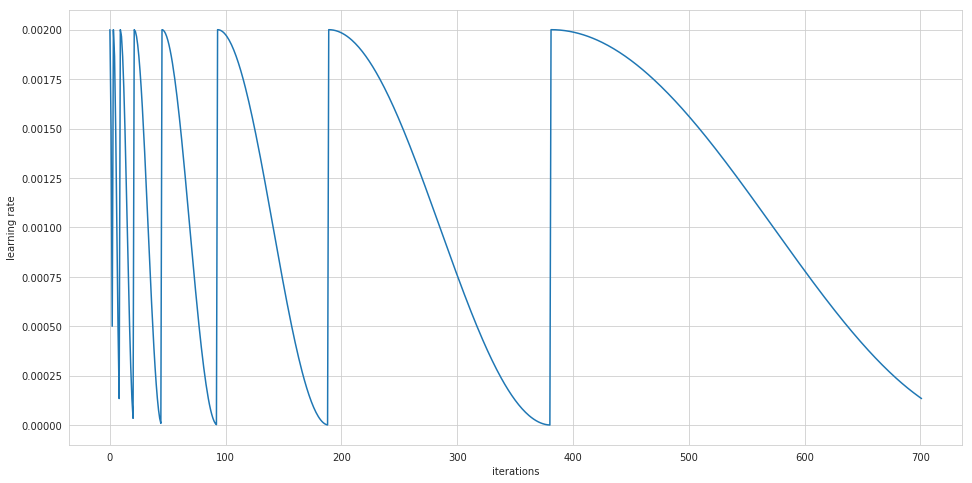

Fold took 551.623s

Running fold 6 / 10
.
1 New best found: 3.5501819973e-07
.
2 New best found: 3.3490954288e-07
.
3 New best found: 3.20547048682e-07
.
4 New best found: 2.9735937951e-07
.
5 New best found: 2.76561406599e-07
.
6 New best found: 2.64344198558e-07
.
7 New best found: 2.59775758104e-07
.
8 New best found: 2.46475650533e-07
.
9 New best found: 2.27926922912e-07
.
10 New best found: 2.16386835393e-07
.
11 New best found: 2.09298563232e-07
.
12 New best found: 2.04361918748e-07
.
13 New best found: 2.01828527895e-07
.
14 New best found: 2.00649733074e-07
.
15 New best found: 2.00532990493e-07
.
16 New best found: 1.96996100181e-07
.
17 New best found: 1.91626494131e-07
.
18 New best found: 1.87264929809e-07
.
19 New best found: 1.8429459991e-07
.
20 New best found: 1.81432437955e-07
.
21 New best found: 1.79418446874e-07
.
22 New best found: 1.77300009818e-07
.
23 New best found: 1.76114706574e-07
.
24 New best found: 1.74917756146e-07
.
25 New best found: 1.74461375184e-0

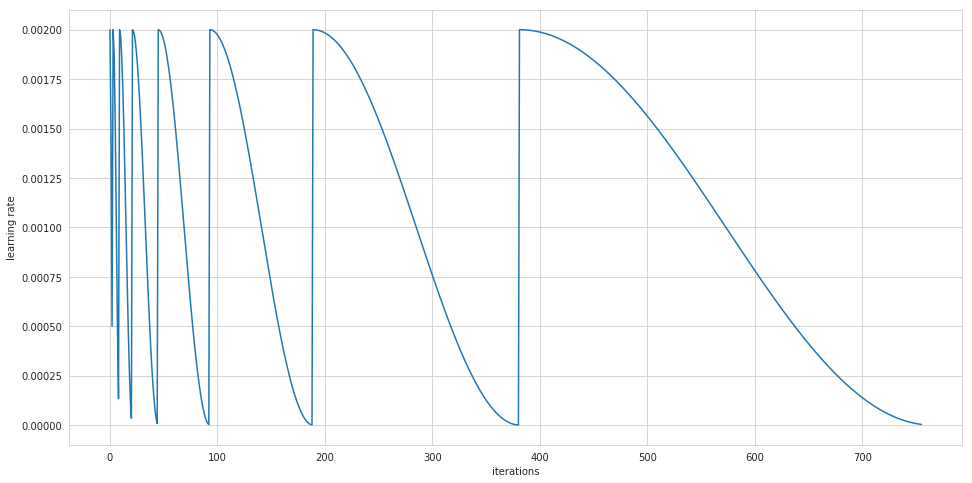

Fold took 575.269s

Running fold 7 / 10
.
1 New best found: 2.30820276761e-07
.
2 New best found: 2.28570718468e-07
.
3 New best found: 2.26109003586e-07
.
4 New best found: 2.23312687092e-07
.
5 New best found: 2.19595666169e-07
.
6 New best found: 2.17064724507e-07
.
7 New best found: 2.16943432281e-07
.
8 New best found: 2.1280483428e-07
.
9 New best found: 2.09121696514e-07
.
10 New best found: 2.057644861e-07
.
11 New best found: 2.03216819841e-07
.
12 New best found: 2.00918171163e-07
.
13 New best found: 2.00246436691e-07
.
14 New best found: 1.99248847275e-07
..
16 New best found: 1.96415426331e-07
.
17 New best found: 1.93666738903e-07
.
18 New best found: 1.90368368476e-07
.
19 New best found: 1.87830825655e-07
.
20 New best found: 1.85585866438e-07
.
21 New best found: 1.83624823433e-07
.
22 New best found: 1.81931606517e-07
.
23 New best found: 1.80506686274e-07
.
24 New best found: 1.79717004244e-07
.
25 New best found: 1.78823484839e-07
.
26 New best found: 1.78208153716e

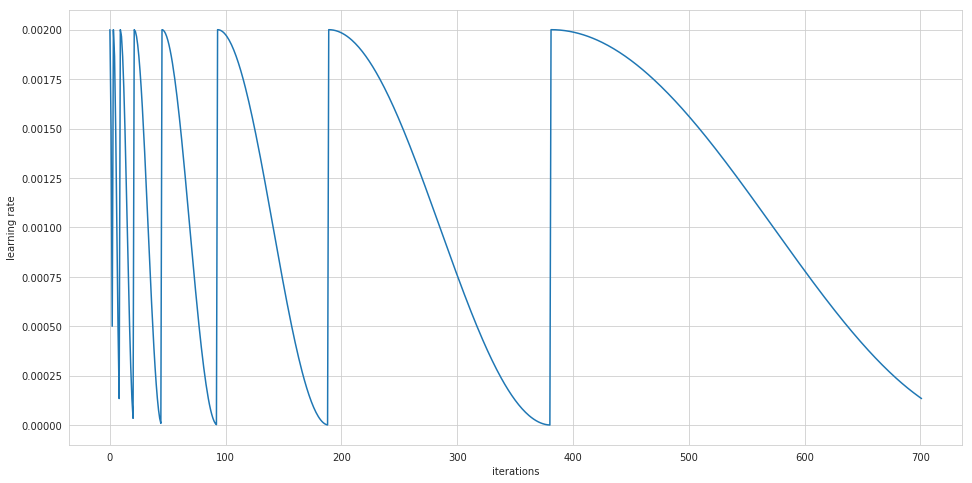

Fold took 530.883s

Running fold 8 / 10
.
1 New best found: 2.37865851422e-07
.
2 New best found: 2.3200229827e-07
.
3 New best found: 2.29046707647e-07
.
4 New best found: 2.24134790751e-07
.
5 New best found: 2.17692631938e-07
.
6 New best found: 2.14836522484e-07
.
7 New best found: 2.13823373821e-07
.
8 New best found: 2.10186507337e-07
.
9 New best found: 2.05876813205e-07
.
10 New best found: 2.02130958949e-07
.
11 New best found: 1.99495616577e-07
.
12 New best found: 1.98013491518e-07
.
13 New best found: 1.96135926312e-07
.
14 New best found: 1.9610407102e-07
..
16 New best found: 1.93751232182e-07
.
17 New best found: 1.91230056416e-07
.
18 New best found: 1.88997406879e-07
.
19 New best found: 1.87296760944e-07
.
20 New best found: 1.85451894475e-07
.
21 New best found: 1.83927819248e-07
.
22 New best found: 1.82600520982e-07
.
23 New best found: 1.81646118935e-07
.
24 New best found: 1.81024295007e-07
.
25 New best found: 1.80353898741e-07
.
26 New best found: 1.79702070172

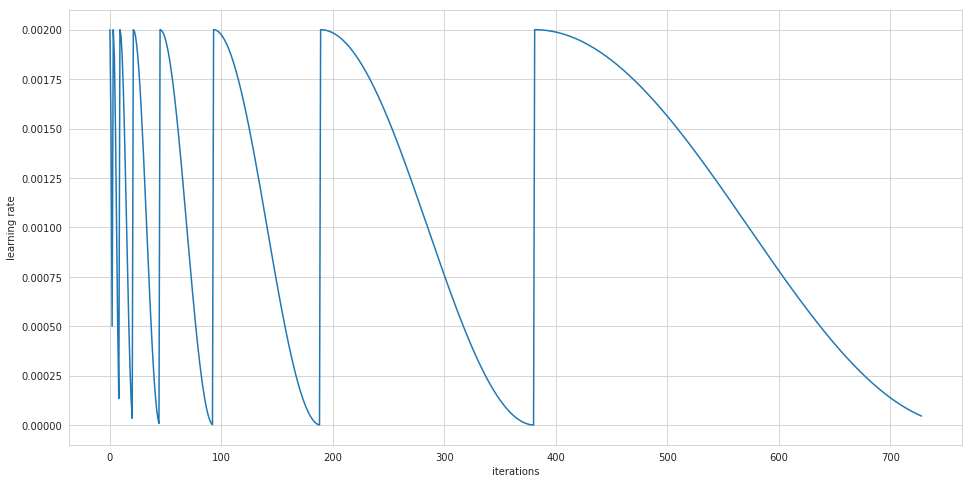

Fold took 551.451s

Running fold 9 / 10
.
1 New best found: 3.78987023764e-07
.
2 New best found: 3.57130069264e-07
.
3 New best found: 3.42407150475e-07
.
4 New best found: 3.13004094222e-07
.
5 New best found: 2.83199183439e-07
.
6 New best found: 2.68050374163e-07
.
7 New best found: 2.6348354972e-07
.
8 New best found: 2.46618951069e-07
.
9 New best found: 2.27598169399e-07
.
10 New best found: 2.15890463959e-07
.
11 New best found: 2.08012770259e-07
.
12 New best found: 2.03758069945e-07
.
13 New best found: 2.0112160735e-07
.
14 New best found: 2.01096483568e-07
.
15 New best found: 2.00816377622e-07
.
16 New best found: 1.97215113268e-07
.
17 New best found: 1.9338271713e-07
.
18 New best found: 1.8901257875e-07
.
19 New best found: 1.8671257461e-07
.
20 New best found: 1.84564609006e-07
.
21 New best found: 1.82583450353e-07
.
22 New best found: 1.81193742093e-07
.
23 New best found: 1.80060191317e-07
.
24 New best found: 1.79161901497e-07
.
25 New best found: 1.7860261049e-07


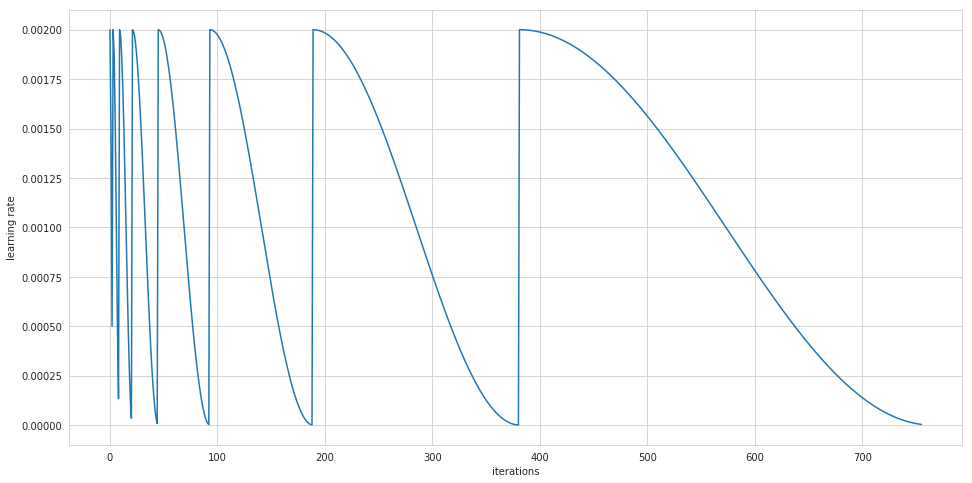

Fold took 584.915s

Running fold 10 / 10
.
1 New best found: 2.43052069641e-07
.
2 New best found: 2.38590172024e-07
.
3 New best found: 2.35944391968e-07
.
4 New best found: 2.31253543082e-07
.
5 New best found: 2.26093241488e-07
.
6 New best found: 2.23681837795e-07
.
7 New best found: 2.23505953448e-07
.
8 New best found: 2.19206815725e-07
.
9 New best found: 2.14742329727e-07
.
10 New best found: 2.10289646507e-07
.
11 New best found: 2.07883988701e-07
.
12 New best found: 2.0599455735e-07
.
13 New best found: 2.04499173488e-07
.
14 New best found: 2.03715997867e-07
..
16 New best found: 2.01653000016e-07
.
17 New best found: 1.98456980219e-07
.
18 New best found: 1.95693217982e-07
.
19 New best found: 1.92685222546e-07
.
20 New best found: 1.90922152977e-07
.
21 New best found: 1.88779013763e-07
.
22 New best found: 1.87382082599e-07
.
23 New best found: 1.85992266622e-07
.
24 New best found: 1.84913763674e-07
.
25 New best found: 1.84039373951e-07
.
26 New best found: 1.833461091

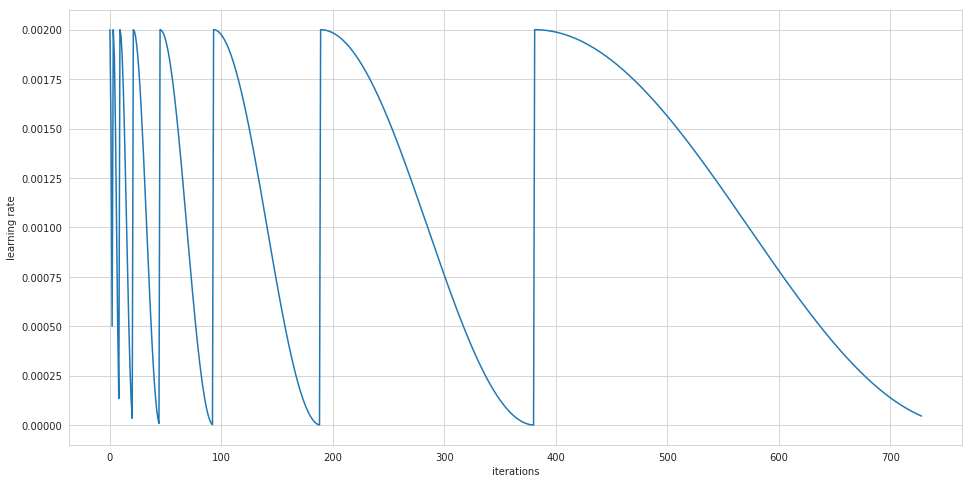

Fold took 496.392s


______________________________________
Training finished
Cross-validation took 5553.018s 
Mean loss = 1.4571e-07 +- 7e-11
Mean AUC = 0.372 +- 0.007
Mean cut = 0.94 +- 0.02
Mean wAUC = 0.376 +- 0.01
Mean AMS = 1.11 +- 0.01
______________________________________



In [7]:
results, histories = batchTrainClassifier(trainData, nSplits, getModel, newModelArgs,
                                          trainParams, trainOnWeights=True, maxEpochs=maxEpochs,
                                          cosAnnealMult=2, plotLR=plot_while_training, 
                                          plot=plotLoss,
                                          reduxDecay=1,
                                          stopIfStallingTest=25,
                                          patience=patience, verbose=1, amsSize=250000)

The impact of data augmentation is pretty clear. Comparing the training here to that of the the CRL Swish model without augmentation we can see that we effectively gain another LR cycles worth of training epochs before we start overfitting, which allows the networks to reach much lower looses (3.18e-5 c.f. 3.23e-5) and a higher AMSs (3.98 c.f. 3.71)

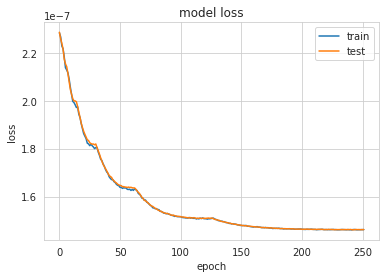

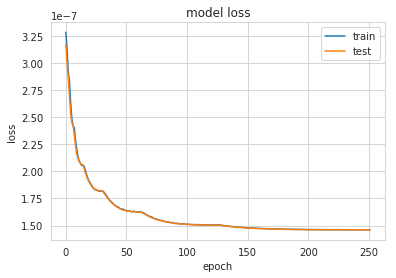

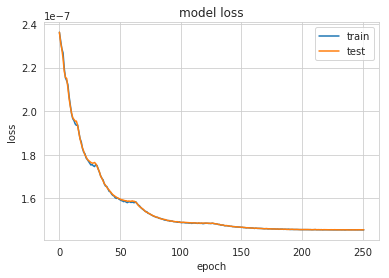

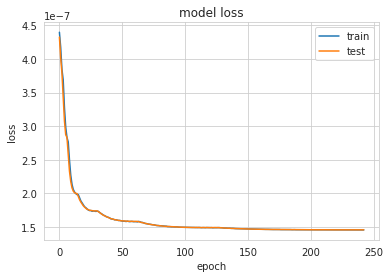

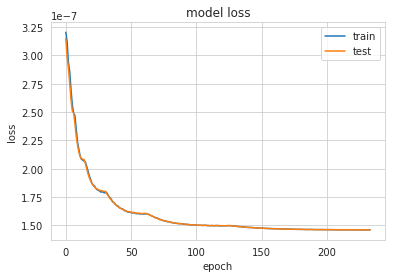

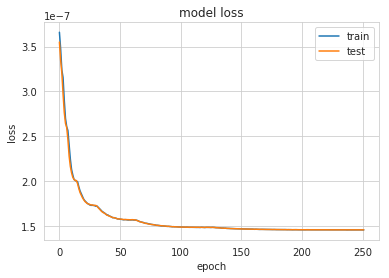

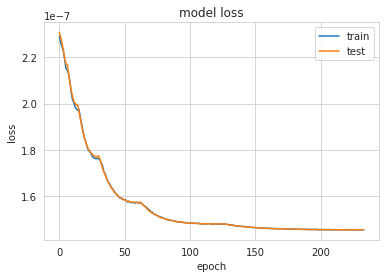

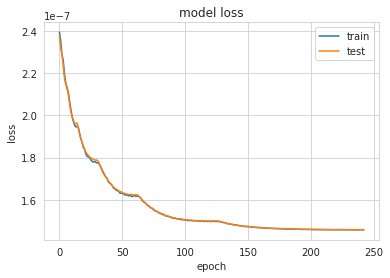

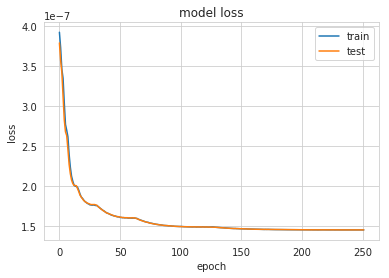

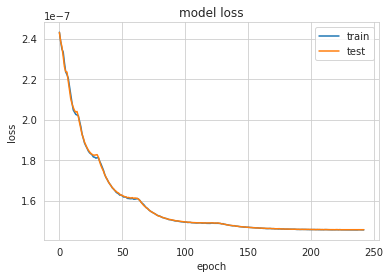

In [10]:
for h in histories:
    plotLoss(h)

## Construct ensemble

In [6]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [7]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs, custom_objects=custom_objects)

('Choosing ensemble by', 'loss')
('Model', 0, 'is', 6, 'with', 'loss', '=', 1.4542360033829027e-07)
('Model', 1, 'is', 2, 'with', 'loss', '=', 1.4551014314318557e-07)
('Model', 2, 'is', 5, 'with', 'loss', '=', 1.4553030898696307e-07)
('Model', 3, 'is', 9, 'with', 'loss', '=', 1.4554968615146175e-07)
('Model', 4, 'is', 3, 'with', 'loss', '=', 1.4569428411732587e-07)
('Model', 5, 'is', 8, 'with', 'loss', '=', 1.4570228837560025e-07)
('Model', 6, 'is', 7, 'with', 'loss', '=', 1.4572410393341087e-07)
('Model', 7, 'is', 1, 'with', 'loss', '=', 1.4593284791484817e-07)
('Model', 8, 'is', 4, 'with', 'loss', '=', 1.4595159929058356e-07)
('Model', 9, 'is', 0, 'with', 'loss', '=', 1.4608987496484477e-07)


## Response on validation data without TTA

In [8]:
valData = BatchYielder(h5py.File(dirLoc + 'val.hdf5', "r+"))

In [9]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=ensembleSize, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.00171852397919s per sample

Predicting batch 2 out of 10
Prediction took 0.000599164581299s per sample

Predicting batch 3 out of 10
Prediction took 0.000581947183609s per sample

Predicting batch 4 out of 10
Prediction took 0.000493705177307s per sample

Predicting batch 5 out of 10
Prediction took 0.000486788988113s per sample

Predicting batch 6 out of 10
Prediction took 0.000494732570648s per sample

Predicting batch 7 out of 10
Prediction took 0.000599936819077s per sample

Predicting batch 8 out of 10
Prediction took 0.000639329814911s per sample

Predicting batch 9 out of 10
Prediction took 0.000511517810822s per sample

Predicting batch 10 out of 10
Prediction took 0.000605508995056s per sample



In [10]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source))))

Testing ROC AUC: unweighted 0.664889643094, weighted 0.675817079073


In [13]:
amsScanSlow(convertToDF(valData.source))

50000 candidates loaded


(3.904678569217358, 0.9597285)

In [14]:
%%time
bootstrapMeanAMS(convertToDF(valData.source), N=512)

50000 candidates loaded

Mean AMS=4.0+-0.2, at mean cut of 0.96+-0.01
Exact mean cut 0.9617856123950332, corresponds to AMS of 3.8858269819333286
CPU times: user 684 ms, sys: 8.5 s, total: 9.19 s
Wall time: 38.5 s


(4.0, 0.96)

With test-time augmentation we improve on 4_Model_Swish_Cyclical-LR in all metrics on validation data: overall AMS 3.77->3.90, AMS corresponding to mean cut 3.72->3.89.

## Response on validation data with TTA

In [17]:
valData = TargetModReader(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                          rotate = True, reflect = True, augRotMult=8)


In [18]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=ensembleSize, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.021259012413s per sample

Predicting batch 2 out of 10
Prediction took 0.0215919509888s per sample

Predicting batch 3 out of 10
Prediction took 0.0213219768047s per sample

Predicting batch 4 out of 10
Prediction took 0.020539623785s per sample

Predicting batch 5 out of 10
Prediction took 0.020959346199s per sample

Predicting batch 6 out of 10
Prediction took 0.0205147325993s per sample

Predicting batch 7 out of 10
Prediction took 0.0205321032047s per sample

Predicting batch 8 out of 10
Prediction took 0.0199405235767s per sample

Predicting batch 9 out of 10
Prediction took 0.0203309484005s per sample

Predicting batch 10 out of 10
Prediction took 0.0192236710072s per sample



In [19]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source))))

Testing ROC AUC: unweighted 0.665886211448, weighted 0.676987918447


In [18]:
amsScanSlow(convertToDF(valData.source))

50000 candidates loaded


(3.966941152482784, 0.959765)

In [19]:
%%time
bootstrapMeanAMS(convertToDF(valData.source), N=512)

50000 candidates loaded

Mean AMS=4.0+-0.2, at mean cut of 0.962+-0.01
Exact mean cut 0.9619597619166598, corresponds to AMS of 3.9122062307167265
CPU times: user 458 ms, sys: 8.84 s, total: 9.29 s
Wall time: 38.6 s


(4.0, 0.962)

Adding test-time augmentation provides further benefits: overall AMS 3.90->3.97, AMS corresponding to mean cut 3.89->3.91.

# Test scoring

In [11]:
testData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                   rotate = True, reflect = True, augRotMult=8)

In [12]:
%%time
batchEnsemblePredict(ensemble, weights, testData, ensembleSize=ensembleSize, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.003736206955599978s per sample

Predicting batch 2 out of 10
Prediction took 0.003723019516363638s per sample

Predicting batch 3 out of 10
Prediction took 0.0037412601151636245s per sample

Predicting batch 4 out of 10
Prediction took 0.0037683697776000123s per sample

Predicting batch 5 out of 10
Prediction took 0.00376735288072728s per sample

Predicting batch 6 out of 10
Prediction took 0.003799426003654563s per sample

Predicting batch 7 out of 10
Prediction took 0.003743513599072718s per sample

Predicting batch 8 out of 10
Prediction took 0.0037143907830909234s per sample

Predicting batch 9 out of 10
Prediction took 0.0037075131608909117s per sample

Predicting batch 10 out of 10
Prediction took 0.0037035181893091s per sample

CPU times: user 40min 54s, sys: 5min 59s, total: 46min 54s
Wall time: 34min 17s


In [28]:
scoreTestOD(testData.source, 0.9619597619166598)

Public:Private AMS: 3.6485448160879015 : 3.8176568398761934


(3.6485448160879015, 3.8176568398761934)

Using the cuts we optimised by bootstrapping the validation data, we end up with a private score which would have beaten the winning entry (3.817 c.f. 3.806). It would be nice if the public score were higher, though.

# Save/Load

In [4]:
name = "weights/Swish_CLR_TTA"

In [31]:
saveEnsemble(name, ensemble, weights, compileArgs, overwrite=1)

In [5]:
ensemble, weights, compileArgs, _, _ = loadEnsemble(name)

## Plots for s/sqrt(s+b) training

(50000, 'candidates loaded')


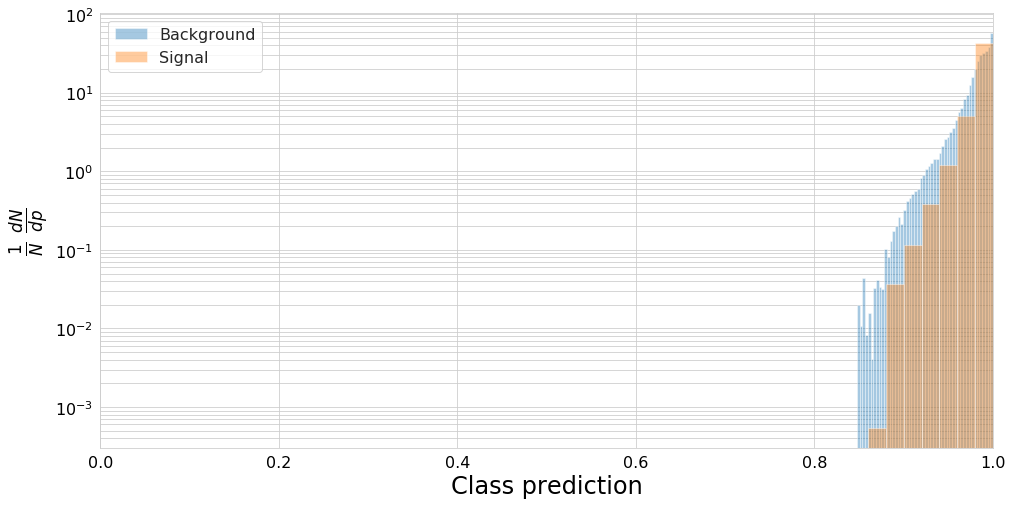

In [20]:
# TODO log-x

d = convertToDF(valData.source)
bkg_sig_dfs = [
    d[d['gen_target']==0],
    d[d['gen_target']==1],
]
getClassPredPlot(bkg_sig_dfs, weightName='gen_weight')

(50000, 'candidates loaded')
0 ROC AUC: 0.676987918447


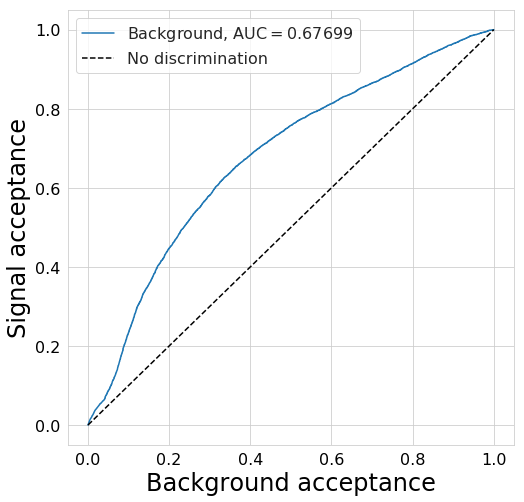

In [21]:
rocPlot([convertToDF(valData.source)], weightName='gen_weight', labels=['Background', 'Signal'])

(50000, 'candidates loaded')


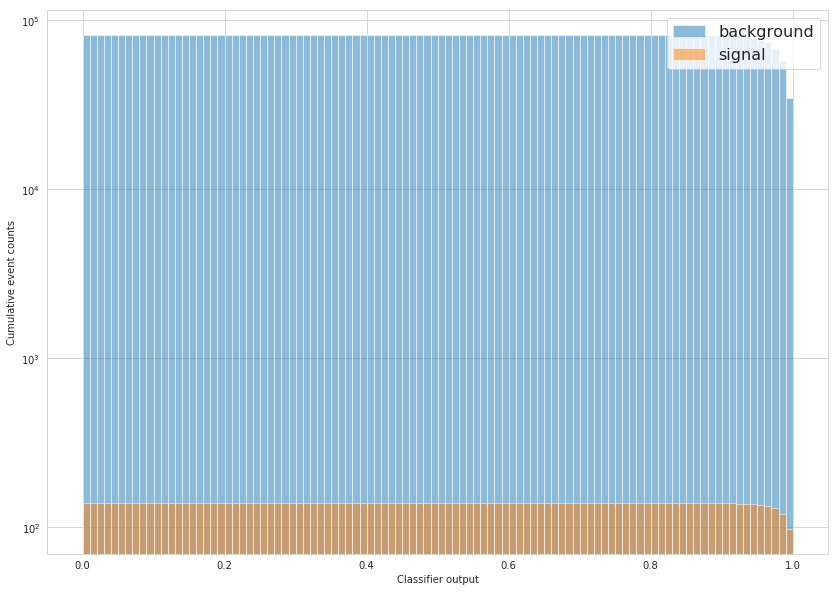

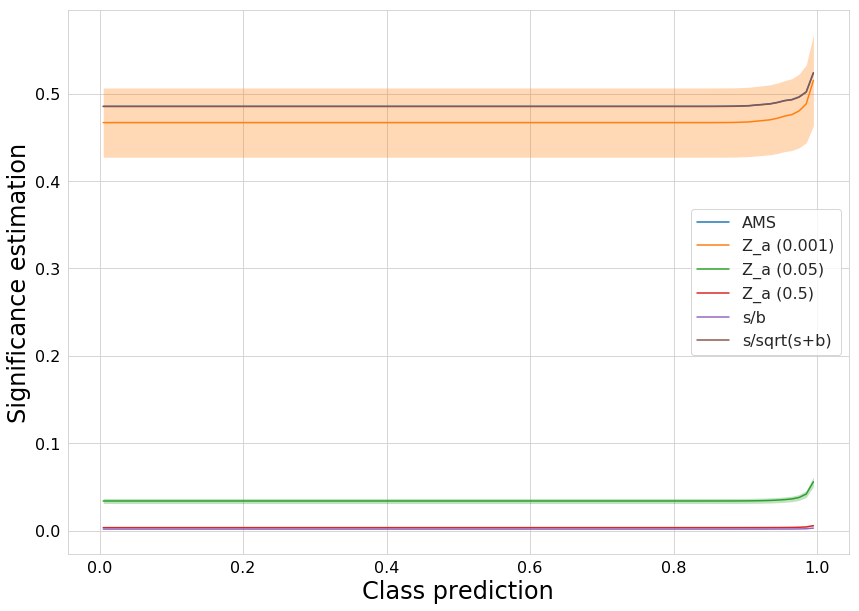

In [22]:
src = valData
#src = testData

from numpy import sqrt, log, power

def get_asimov(systematic):
    return lambda s,b: (Z_asimov(s,b, systematic), eZ_asimov(s,sqrt(s),b,sqrt(b),systematic))

h1 = plotSignificanceEstimate(
    convertToDF(src.source), 
    {
        's/b': lambda s,b: s/b,
        's/sqrt(s+b)': lambda s,b: s/np.sqrt(s+b),
        'Z_a (0.5)': get_asimov(0.5),
        'Z_a (0.05)': get_asimov(0.05),
        'Z_a (0.001)': get_asimov(0.001),
        'AMS': AMS,
#        'asimov err': lambda s,b: eZ(s,sqrt(s),b,sqrt(b)),
    },
    weightName='gen_weight',
    figsize=(14, 10),
    nBins=100,
)

## Plots for cross-entropy

(50000, 'candidates loaded')


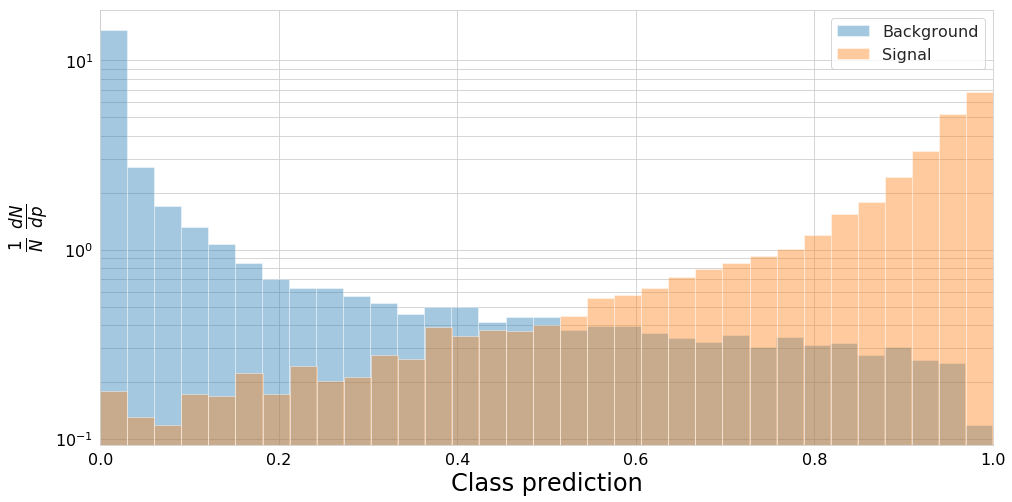

In [14]:
# TODO log-x

d = convertToDF(valData.source)
bkg_sig_dfs = [
    d[d['gen_target']==0],
    d[d['gen_target']==1],
]
getClassPredPlot(bkg_sig_dfs, weightName='gen_weight')

(50000, 'candidates loaded')
0 ROC AUC: 0.936007816299


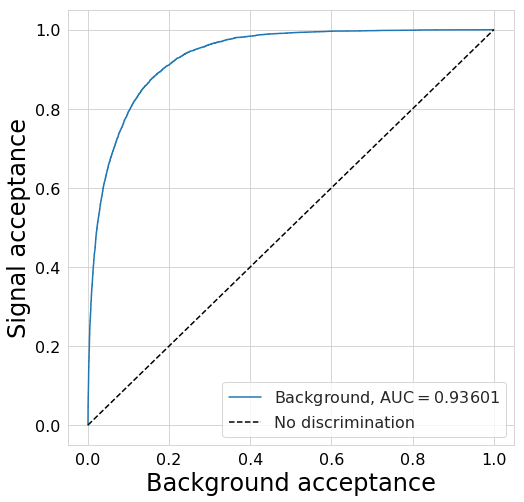

In [15]:
rocPlot([convertToDF(valData.source)], weightName='gen_weight', labels=['Background', 'Signal'])

(50000, 'candidates loaded')


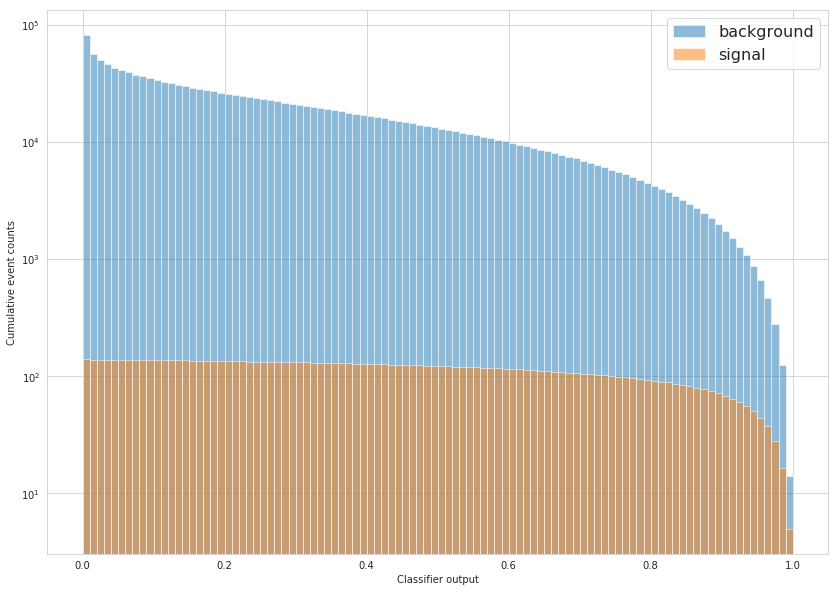

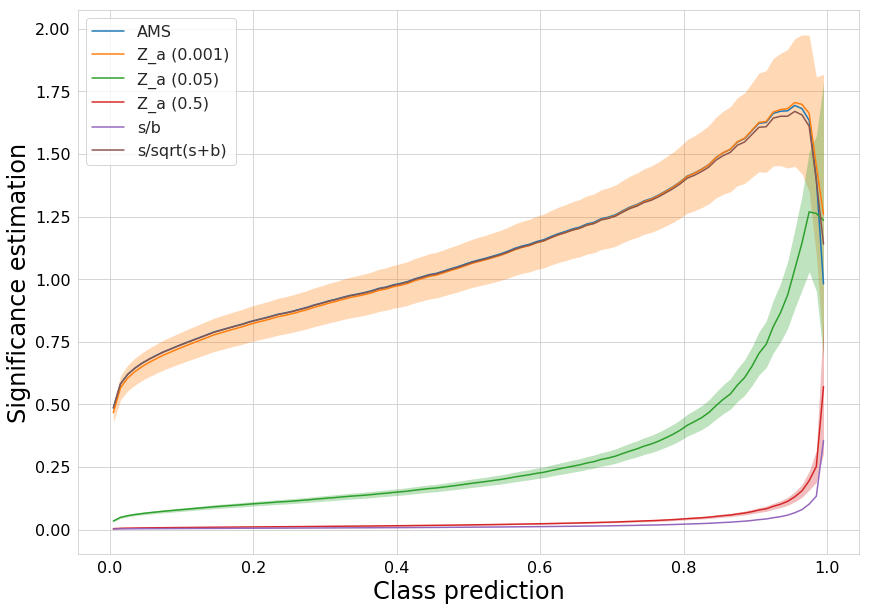

In [17]:
src = valData
#src = testData

from numpy import sqrt, log, power

def get_asimov(systematic):
    return lambda s,b: (Z_asimov(s,b, systematic), eZ_asimov(s,sqrt(s),b,sqrt(b),systematic))

h1 = plotSignificanceEstimate(
    convertToDF(src.source), 
    {
        's/b': lambda s,b: s/b,
        's/sqrt(s+b)': lambda s,b: s/np.sqrt(s+b),
        'Z_a (0.5)': get_asimov(0.5),
        'Z_a (0.05)': get_asimov(0.05),
        'Z_a (0.001)': get_asimov(0.001),
        'AMS': AMS,
#        'asimov err': lambda s,b: eZ(s,sqrt(s),b,sqrt(b)),
    },
    weightName='gen_weight',
    figsize=(14, 10),
    nBins=100,
)